# HWA5

## Algorithms + Databases

In [127]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os
import sys
import math
import csv

import matplotlib.pyplot as plt
import seaborn as sns

from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split 
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import Ridge
from sklearn.mixture import GaussianMixture

# the new model
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten


from sklearn import metrics
from sklearn.metrics import classification_report 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [6]:
# Function importing Dataset 
def importdata(trainFile, testFile, skipTrain, skipTest): 
    train = pd.read_csv(trainFile, sep= ',', header = None, skiprows=skipTrain) 
    test = pd.read_csv(testFile, sep= ',', header = None, skiprows=skipTest) 
    return train, test    

# Function to split target from data 
def splitdataset(train, test): 
    ohe = OneHotEncoder(sparse=True)
    objInTrain = len(train)

    allData = pd.concat([train, test], ignore_index=True, sort =False, axis=0)
    AllDataWihoutClass = allData.iloc[:, :-1]
    AllDataWihoutClassOnlyNominals = AllDataWihoutClass.select_dtypes(include=['object'])
    AllDataWihoutClassNoNominals = AllDataWihoutClass.select_dtypes(exclude=['object'])

    encAllDataWihoutClassNominals = ohe.fit_transform(AllDataWihoutClassOnlyNominals)
    encAllDataWihoutClassNominalsToPanda = pd.DataFrame(encAllDataWihoutClassNominals.toarray())
    
    if AllDataWihoutClassOnlyNominals.shape[1] > 0:
      codAllDataAgain = pd.concat([encAllDataWihoutClassNominalsToPanda, AllDataWihoutClassNoNominals], ignore_index=True, sort =False, axis=1)
    else:
      codAllDataAgain = AllDataWihoutClass

    # Seperating the target variable 
    X_train = codAllDataAgain[:objInTrain]
    y_train = train.values[:, -1]

    X_test = codAllDataAgain[objInTrain:]
    y_test = test.values[:, -1]
    
    mm_scaler = MinMaxScaler()
    X_train_minmax = pd.DataFrame(mm_scaler.fit_transform(X_train[X_train.columns]), index=X_train.index, columns=X_train.columns)
    X_test_minmax = pd.DataFrame(mm_scaler.transform(X_test[X_test.columns]), index=X_test.index, columns=X_test.columns)
    
    std_scaler = StandardScaler()
    X_train_std = pd.DataFrame(std_scaler.fit_transform(X_train[X_train.columns]), index=X_train.index, columns=X_train.columns)
    X_test_std = pd.DataFrame(std_scaler.transform(X_test[X_test.columns]), index=X_test.index, columns=X_test.columns)
    
    X_train_minmax_std = pd.DataFrame(std_scaler.fit_transform(X_train_minmax[X_train_minmax.columns]), index=X_train_minmax.index, columns=X_train_minmax.columns)
    X_test_minmax_std = pd.DataFrame(std_scaler.transform(X_test_minmax[X_test_minmax.columns]), index=X_test_minmax.index, columns=X_test_minmax.columns)
    
    return X_train, X_test, y_train, y_test, X_train_minmax, X_test_minmax, X_train_std, X_test_std, X_train_minmax_std, X_test_minmax_std

# Function to make predictions 
def prediction(X_test, clf_object):  
    y_pred = clf_object.score_samples(X_test) 
    return y_pred 

def result_of_Class(y_test, y_pred, saveFile):       
    np.savetxt(saveFile, y_pred, fmt='%.4f')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%cd /content/drive/MyDrive/Colab Notebooks/Databases
%ls

/content/drive/MyDrive/Colab Notebooks/Databases
 abalone-17_vs_7-8-9-10/
 abalone19/
 abalone-19_vs_10-11-12-13/
 abalone-20_vs_8-9-10/
 abalone-21_vs_8/
 abalone-3_vs_11/
 abalone9-18/
 BRM_results.csv
 car-good/
 car-vgood/
'<class '\''sklearn.svm._classes.OneClassSVM'\''>_results.csv'
 cleveland-0_vs_4/
 dermatology-6/
 ecoli-0-1-3-7_vs_2-6/
 ecoli-0-1-4-6_vs_5/
 ecoli-0-1-4-7_vs_2-3-5-6/
 ecoli-0-1-4-7_vs_5-6/
 ecoli-0-1_vs_2-3-5/
 ecoli-0-1_vs_5/
 ecoli-0-2-3-4_vs_5/
 ecoli-0-2-6-7_vs_3-5/
 ecoli-0-3-4-6_vs_5/
 ecoli-0-3-4-7_vs_5-6/
 ecoli-0-3-4_vs_5/
 ecoli-0-4-6_vs_5/
 ecoli-0-6-7_vs_3-5/
 ecoli-0-6-7_vs_5/
 ecoli-0_vs_1/
 ecoli1/
 ecoli2/
 ecoli3/
 ecoli4/
 flare-F/
 GaussianMixture_results.csv
 glass0/
 glass-0-1-2-3_vs_4-5-6/
 glass-0-1-4-6_vs_2/
 glass-0-1-5_vs_2/
 glass-0-1-6_vs_2/
 glass-0-1-6_vs_5/
 glass-0-4_vs_5/
 glass-0-6_vs_5/
 glass1/
 glass2/
 glass4/
 glass5/
 glass6/
 habermanImb/
 HWA5_results.csv
 iris0/
 IsolationForest_results.csv
 kr-vs-k-one_vs_fifteen/
 k

In [93]:
models_df = pd.DataFrame()

data_2 = {
    'Database': [],
    'AUC': [],
    'Normalization': [],
    'Classifier': [],
}

In [94]:
def apply_classifier(rootDir, classifier, str_classifier, normalization=None):
  print('Implementing', str_classifier, '...')
  clf_classif = classifier()

  data = {
    'Database': [],
    'AUC': [],
  }

  i = 0
  for dirName, subdirList, fileList in os.walk(rootDir):
      #print('Directorio encontrado: %s' % dirName)
      #print("************************************ DIRECTORIO **************************************")

      if i == 0:
        i += 1

        continue

      if len(fileList) > 0:
          arr_auc = []
          arr_folder_name = dirName.split("/")
          folder_name = arr_folder_name[len(arr_folder_name) - 1]
          completed_name = folder_name + "-5-"
          for i in range(len(fileList)):
              #print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DATASET !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!") 
              trainFile = str(dirName) + '/' + completed_name + "1tra.dat"
              testFile = str(dirName) + '/' + completed_name + "1tst.dat"
              #print('trainFile ' + trainFile)
              #print('testFile ' + testFile)

              with open(trainFile) as file:
                skipTrain = 0
                for line in file:
                    skipTrain += 1
                    
                    if line[0] != '@':
                      break

              with open(testFile) as file:
                skipTest = 0
                for line in file:
                    skipTest += 1
                    
                    if line[0] != '@':
                      break

              # Loading data 
              train, test = importdata(trainFile, testFile, skipTrain - 1, skipTest - 1)

              # Training
              X_train, X_test, y_train, y_test, X_train_minmax, X_test_minmax, X_train_std, X_test_std, X_train_minmax_std, X_test_minmax_std = splitdataset(train, test)

              auc = 0
              if normalization is None:
                # Performing training 
                clf_classif.fit(X_train, y_train) 

                # Operational Phase 
                y_pred_classif = prediction(X_test, clf_classif) 

                auc = metrics.roc_auc_score(y_test,  y_pred_classif)
              elif normalization is 'MinMax':
                # Performing training 
                clf_classif.fit(X_train_minmax, y_train) 

                # Operational Phase 
                y_pred_classif = prediction(X_test_minmax, clf_classif) 

                auc = metrics.roc_auc_score(y_test,  y_pred_classif)
              elif normalization is 'Std':
                # Performing training 
                clf_classif.fit(X_train_std, y_train) 

                # Operational Phase 
                y_pred_classif = prediction(X_test_std, clf_classif) 

                auc = metrics.roc_auc_score(y_test,  y_pred_classif)
              
              arr_auc.append(1 - auc if auc < 0.5 else auc)
              #print("AUC: "+str(1 - auc if auc < 0.5 else auc))
              #print(y_pred_classif)
          
          #print('AUC!! ' + str(arr_auc))
          aver_auc = sum(arr_auc) / len(arr_auc)
          #print('aver_auc!! ' + str(aver_auc))
          data['Database'].append(folder_name)
          data['AUC'].append(aver_auc)

          data_2['Database'].append(folder_name)
          data_2['AUC'].append(aver_auc)
          data_2['Classifier'].append(str_classifier)
          data_2['Normalization'].append(str(normalization))
          #print('data[auc] ' + str(data['auc']))

      df = pd.DataFrame(data, columns = ['Database', 'AUC'])    
      df.to_csv(rootDir + str_classifier + '_' + str(normalization)  + '_results.csv')

  print(str_classifier, 'implemented')

In [98]:
!pip install brminer

In [116]:
from brminer import BRM

#### Normalization: None

In [95]:
rootDir = '/content/drive/MyDrive/Colab Notebooks/Databases/'

apply_classifier(rootDir, OneClassSVM, 'OneClassSVM')
apply_classifier(rootDir, IsolationForest, 'IsolationForest')
apply_classifier(rootDir, GaussianMixture, 'GaussianMixture')
apply_classifier(rootDir, BRM, 'BRM')

Implementing OneClassSVM ...
OneClassSVM implemented


#### Normalization: MinMax

In [117]:
apply_classifier(rootDir, OneClassSVM, 'OneClassSVM', normalization='MinMax')
apply_classifier(rootDir, IsolationForest, 'IsolationForest', normalization='MinMax')
apply_classifier(rootDir, GaussianMixture, 'GaussianMixture', normalization='MinMax')
apply_classifier(rootDir, BRM, 'BRM', normalization='MinMax')

Implementing OneClassSVM ...
OneClassSVM implemented
Implementing IsolationForest ...
IsolationForest implemented
Implementing GaussianMixture ...
GaussianMixture implemented
Implementing BRM ...
BRM implemented


#### Normalization: Standard Scaler

In [118]:
apply_classifier(rootDir, OneClassSVM, 'OneClassSVM', normalization='Std')
apply_classifier(rootDir, IsolationForest, 'IsolationForest', normalization='Std')
apply_classifier(rootDir, GaussianMixture, 'GaussianMixture', normalization='Std')
apply_classifier(rootDir, BRM, 'BRM', normalization='Std')

Implementing OneClassSVM ...
OneClassSVM implemented
Implementing IsolationForest ...
IsolationForest implemented
Implementing GaussianMixture ...
GaussianMixture implemented
Implementing BRM ...
BRM implemented


## Algorithms + Databases + Statistical Tests + Visualizations

In [129]:
models_df = pd.DataFrame(data_2)
models_df

,Database,AUC,Normalization,Classifier
0,yeast-2_vs_8,0.577957,None,OneClassSVM
1,zoo-3,0.950000,None,OneClassSVM
2,yeast4,0.758106,None,OneClassSVM
3,yeast1,0.560895,None,OneClassSVM
4,yeast3,0.509757,None,OneClassSVM
...,...,...,...,...
1135,abalone-21_vs_8,0.989766,Std,BRM
1136,abalone-19_vs_10-11-12-13,0.586478,Std,BRM
1137,abalone-20_vs_8-9-10,0.847002,Std,BRM
1138,abalone-3_vs_11,0.687075,Std,BRM


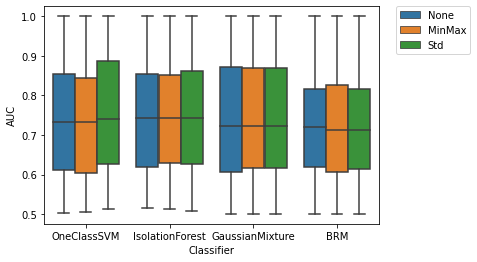

In [130]:
sns.boxplot(x='Classifier', y='AUC', hue='Normalization', data=models_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

### Normalization: None

#### Friedman's test

In [165]:
import scipy.stats as st

In [166]:
# Credits: https://github.com/citiususc/stac/blob/master/stac/nonparametric_tests.py
# Implementation: https://github.com/citiususc/stac/blob/master/stac/unit_tests.py

def friedman_test(*args):
    """
        Performs a Friedman ranking test.
        Tests the hypothesis that in a set of k dependent samples groups (where k >= 2) at least two of the groups represent populations with different median values.
        
        Parameters
        ----------
        sample1, sample2, ... : array_like
            The sample measurements for each group.
            
        Returns
        -------
        F-value : float
            The computed F-value of the test.
        p-value : float
            The associated p-value from the F-distribution.
        rankings : array_like
            The ranking for each group.
        pivots : array_like
            The pivotal quantities for each group.
            
        References
        ----------
        M. Friedman, The use of ranks to avoid the assumption of normality implicit in the analysis of variance, Journal of the American Statistical Association 32 (1937) 674–701.
        D.J. Sheskin, Handbook of parametric and nonparametric statistical procedures. crc Press, 2003, Test 25: The Friedman Two-Way Analysis of Variance by Ranks
    """
    k = len(args)
    if k < 2: raise ValueError('Less than 2 levels')
    n = len(args[0])
    if len(set([len(v) for v in args])) != 1: raise ValueError('Unequal number of samples')

    rankings = []
    for i in range(n):
        row = [col[i] for col in args]
        row_sort = sorted(row)
        rankings.append([row_sort.index(v) + 1 + (row_sort.count(v)-1)/2. for v in row])

    rankings_avg = [np.mean([case[j] for case in rankings]) for j in range(k)]
    rankings_cmp = [r/np.sqrt(k*(k+1)/(6.*n)) for r in rankings_avg]

    chi2 = ((12*n)/float((k*(k+1))))*((np.sum(r**2 for r in rankings_avg))-((k*(k+1)**2)/float(4)))
    iman_davenport = ((n-1)*chi2)/float((n*(k-1)-chi2))

    p_value = 1 - st.f.cdf(iman_davenport, k-1, (k-1)*(n-1))

    return rankings_avg

In [169]:
classifiers = np.unique(models_df.Classifier)
normalization = np.unique(models_df.Normalization)

In [170]:
dic = {}

for i in classifiers:
  for j in normalization:
    dic[f'AUC_{i}_{j}'] = models_df[(models_df.Classifier == i) & (models_df.Normalization == j)].AUC.values

final_df = pd.DataFrame(dic)
final_df

,AUC_BRM_MinMax,AUC_BRM_None,AUC_BRM_Std,AUC_GaussianMixture_MinMax,AUC_GaussianMixture_None,AUC_GaussianMixture_Std,AUC_IsolationForest_MinMax,AUC_IsolationForest_None,AUC_IsolationForest_Std,AUC_OneClassSVM_MinMax,AUC_OneClassSVM_None,AUC_OneClassSVM_Std
0,0.631720,0.633065,0.631720,0.647849,0.647849,0.647849,0.639785,0.616935,0.623656,0.577957,0.577957,0.626344
1,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.625000,0.600000,0.600000,0.950000,0.950000,0.900000
2,0.686586,0.683249,0.687540,0.734584,0.734584,0.734584,0.725048,0.733153,0.743166,0.764781,0.758106,0.727908
3,0.527609,0.531329,0.527444,0.552904,0.552904,0.552904,0.539265,0.519619,0.537860,0.555274,0.560895,0.555770
4,0.531795,0.534780,0.532254,0.587810,0.587810,0.587810,0.514692,0.516472,0.533804,0.515381,0.509757,0.521350
...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.992690,0.991228,0.989766,0.985380,0.985380,0.985380,0.913743,0.932749,0.932749,0.891813,0.856725,0.956140
91,0.600629,0.588724,0.586478,0.615903,0.616352,0.615903,0.625112,0.627134,0.610063,0.650943,0.639712,0.561096
92,0.846340,0.843034,0.847002,0.854056,0.854056,0.854056,0.637125,0.657848,0.663139,0.518078,0.503527,0.758818
93,0.678571,0.688776,0.687075,0.982993,0.982993,0.982993,0.991497,0.998299,0.996599,1.000000,0.976190,1.000000


In [171]:
alpha = 0.05 # significance level

result = stats.friedmanchisquare(final_df.AUC_OneClassSVM_None, final_df.AUC_IsolationForest_None, final_df.AUC_GaussianMixture_None, final_df.AUC_BRM_None)
result

FriedmanchisquareResult(statistic=4.5415778251599175, pvalue=0.2086114881226235)

In [172]:
if result.pvalue < alpha:
  print("We can reject the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are not similar statistically. Therefore, we can proceed with a post-hoc test.")
else:
  print("We can accept the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are similar statistically.")

We can accept the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are similar statistically.


In [175]:
auc_data_none = {
    'AUC_OneClass_SVM_None': final_df.AUC_OneClassSVM_None,
    'AUC_Isolation_Forest_None': final_df.AUC_IsolationForest_None,
    'AUC_Gaussian_Mixture_None': final_df.AUC_GaussianMixture_None,
    'AUC_BRM_None': final_df.AUC_BRM_None,
}

In [176]:
rankings_avg = friedman_test(*auc_data_none.values())
rankings_avg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


[2.331578947368421, 2.6894736842105265, 2.5736842105263156, 2.405263157894737]

#### Post-hoc test

In [ ]:
!pip install scikit-posthocs

In [178]:
import scikit_posthocs as sp

In [179]:
data = np.array([final_df.AUC_OneClassSVM_None, final_df.AUC_IsolationForest_None, final_df.AUC_GaussianMixture_None, final_df.AUC_BRM_None])

In [180]:
p_values = sp.posthoc_nemenyi_friedman(data.T)
p_values

,0,1,2,3
0,1.000000,0.223596,0.559671,0.900000
1,0.223596,1.000000,0.900000,0.428543
2,0.559671,0.900000,1.000000,0.780471
3,0.900000,0.428543,0.780471,1.000000


In [181]:
import scipy as scp
import itertools as it

In [182]:
def _S(k):
    """
        Helper function for the Shaffer test.
        It obtains the number of independent test hypotheses when using an All vs All strategy using the number of groups to be compared.
    """
    if k == 0 or k == 1:
        return {0}
    else:
        result = set()
        for j in reversed(range(1, k+1)):
            tmp = _S(k - j)
            for s in tmp:
                result = result.union({scp.special.binom(j, 2) + s})
        return list(result)


def shaffer_multitest(ranks):
    """
        Performs a Shaffer post-hoc test using the pivot quantities obtained by a ranking test.
        Tests the hypothesis that the ranking of each pair of groups are different.
        
        Parameters
        ----------
        pivots : dictionary_like
            A dictionary with format 'groupname':'pivotal quantity' 
            
        Returns
        ----------
        Comparions : array-like
            Strings identifier of each comparison with format 'group_i vs group_j'
        Z-values : array-like
            The computed Z-value statistic for each comparison.
        p-values : array-like
            The associated p-value from the Z-distribution wich depends on the index of the comparison
        Adjusted p-values : array-like
            The associated adjusted p-values wich can be compared with a significance level
            
        References
        ----------
        J. Li, A two-step rejection procedure for testing multiple hypotheses, Journal of Statistical Planning and Inference 138 (2008) 1521–1527.
    """
    k = len(ranks)
    values = list(ranks.values())
    keys = list(ranks.keys())
    versus = list(it.combinations(range(k), 2))
    
    m = int(k*(k-1)/2.)
    A = _S(int((1 + np.sqrt(1+4*m*2))/2))
    t = [max([a for a in A if a <= m-i]) for i in range(m)]

    comparisons = [keys[vs[0]] + " vs " + keys[vs[1]] for vs in versus]
    z_values = [abs(values[vs[0]] - values[vs[1]]) for vs in versus]
    p_values = [2*(1-st.norm.cdf(abs(z))) for z in z_values]
    # Sort values by p_value so that p_0 < p_1
    p_values, z_values, comparisons = map(list, zip(*sorted(zip(p_values, z_values, comparisons), key=lambda t: t[0])))
    adj_p_values = [min(max(t[j]*p_values[j] for j in range(i+1)), 1) for i in range(m)]
    
    return comparisons, z_values, p_values, adj_p_values

In [200]:
ranks = {key: rankings_avg[i] for i, key in enumerate(auc_data_none.keys())}
ranks

{'AUC_BRM_None': 2.4157894736842107,
 'AUC_Gaussian_Mixture_None': 2.626315789473684,
 'AUC_Isolation_Forest_None': 2.6210526315789475,
 'AUC_OneClass_SVM_None': 2.336842105263158}

In [184]:
comparisons, z_values, p_values, adj_p_values = shaffer_multitest(ranks)
comparisons, z_values, p_values, adj_p_values

(['AUC_OneClass_SVM_None vs AUC_Isolation_Forest_None',
  'AUC_Isolation_Forest_None vs AUC_BRM_None',
  'AUC_OneClass_SVM_None vs AUC_Gaussian_Mixture_None',
  'AUC_Gaussian_Mixture_None vs AUC_BRM_None',
  'AUC_Isolation_Forest_None vs AUC_Gaussian_Mixture_None',
  'AUC_OneClass_SVM_None vs AUC_BRM_None'],
 [0.3578947368421055,
  0.28421052631578947,
  0.2421052631578946,
  0.16842105263157858,
  0.11578947368421089,
  0.07368421052631602],
 [0.7204220895945663,
  0.7762490491181446,
  0.8086986000940988,
  0.8662520470606498,
  0.9078193931820497,
  0.9412616628068939],
 [1, 1, 1, 1, 1, 1])

In [185]:
def nemenyi_multitest(ranks):
    """
        Performs a Nemenyi post-hoc test using the pivot quantities obtained by a ranking test.
        Tests the hypothesis that the ranking of each pair of groups are different.

        Parameters
        ----------
        pivots : dictionary_like
            A dictionary with format 'groupname':'pivotal quantity' 

        Returns
        ----------
        Comparions : array-like
            Strings identifier of each comparison with format 'group_i vs group_j'
        Z-values : array-like
            The computed Z-value statistic for each comparison.
        p-values : array-like
            The associated p-value from the Z-distribution wich depends on the index of the comparison
        Adjusted p-values : array-like
            The associated adjusted p-values wich can be compared with a significance level

        References
        ----------
        Bonferroni-Dunn: O.J. Dunn, Multiple comparisons among means, Journal of the American Statistical Association 56 (1961) 52–64.
    """
    k = len(ranks)
    values = list(ranks.values())
    keys = list(ranks.keys())
    versus = list(it.combinations(range(k), 2))

    comparisons = [keys[vs[0]] + " vs " + keys[vs[1]] for vs in versus]
    z_values = [abs(values[vs[0]] - values[vs[1]]) for vs in versus]

    p_values = [2 * (1-st.norm.cdf(abs(z))) for z in z_values]
    # Sort values by p_value so that p_0 < p_1
    m = int(k * (k-1)/2.)
    adj_p_values = [min(m*p_value,1) for p_value in p_values]

    return comparisons, z_values, p_values, adj_p_values

In [186]:
comparisons, z_values, p_values, adj_p_values = nemenyi_multitest(ranks)
comparisons, z_values, p_values, adj_p_values

(['AUC_OneClass_SVM_None vs AUC_Isolation_Forest_None',
  'AUC_OneClass_SVM_None vs AUC_Gaussian_Mixture_None',
  'AUC_OneClass_SVM_None vs AUC_BRM_None',
  'AUC_Isolation_Forest_None vs AUC_Gaussian_Mixture_None',
  'AUC_Isolation_Forest_None vs AUC_BRM_None',
  'AUC_Gaussian_Mixture_None vs AUC_BRM_None'],
 [0.3578947368421055,
  0.2421052631578946,
  0.07368421052631602,
  0.11578947368421089,
  0.28421052631578947,
  0.16842105263157858],
 [0.7204220895945663,
  0.8086986000940988,
  0.9412616628068939,
  0.9078193931820497,
  0.7762490491181446,
  0.8662520470606498],
 [1, 1, 1, 1, 1, 1])

#### Critical Difference Diagram

In [ ]:
!pip install Orange3

In [188]:
rankings_avg

[2.331578947368421, 2.6894736842105265, 2.5736842105263156, 2.405263157894737]

In [190]:
final_df.shape

(95, 12)

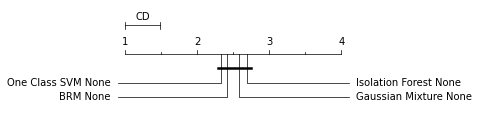

In [191]:
import Orange

names = ['One Class SVM None', 'Isolation Forest None', 'Gaussian Mixture None', 'BRM None']

avranks = [rankings_avg[0], rankings_avg[1], rankings_avg[2], rankings_avg[3]]

cd = Orange.evaluation.compute_CD(avranks, final_df.shape[0])
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
plt.show();

### Normalization: MinMax

#### Friedman's test

In [192]:
alpha = 0.05 # significance level

result = stats.friedmanchisquare(final_df.AUC_OneClassSVM_MinMax, final_df.AUC_IsolationForest_MinMax, final_df.AUC_GaussianMixture_MinMax, final_df.AUC_BRM_MinMax)
result

FriedmanchisquareResult(statistic=3.7572815533980015, pvalue=0.28889425633016286)

In [193]:
if result.pvalue < alpha:
  print("We can reject the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are not similar statistically. Therefore, we can proceed with a post-hoc test.")
else:
  print("We can accept the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are similar statistically.")

We can accept the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are similar statistically.


In [194]:
auc_data_minmax = {
    'AUC_OneClass_SVM_MinMax': final_df.AUC_OneClassSVM_MinMax,
    'AUC_Isolation_Forest_MinMax': final_df.AUC_IsolationForest_MinMax,
    'AUC_Gaussian_Mixture_MinMax': final_df.AUC_GaussianMixture_MinMax,
    'AUC_BRM_MinMax': final_df.AUC_BRM_MinMax,
}

In [195]:
rankings_avg = friedman_test(*auc_data_minmax.values())
rankings_avg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


[2.336842105263158, 2.6210526315789475, 2.626315789473684, 2.4157894736842107]

#### Post-hoc test

In [196]:
data = np.array([final_df.AUC_OneClassSVM_MinMax, final_df.AUC_IsolationForest_MinMax, final_df.AUC_GaussianMixture_MinMax, final_df.AUC_BRM_MinMax])

In [197]:
p_values = sp.posthoc_nemenyi_friedman(data.T)
p_values

,0,1,2,3
0,1.000000,0.428543,0.41172,0.900000
1,0.428543,1.000000,0.90000,0.670069
2,0.411720,0.900000,1.00000,0.654300
3,0.900000,0.670069,0.65430,1.000000


In [199]:
ranks = {key: rankings_avg[i] for i, key in enumerate(auc_data_minmax.keys())}
ranks

{'AUC_BRM_MinMax': 2.4157894736842107,
 'AUC_Gaussian_Mixture_MinMax': 2.626315789473684,
 'AUC_Isolation_Forest_MinMax': 2.6210526315789475,
 'AUC_OneClass_SVM_MinMax': 2.336842105263158}

In [201]:
comparisons, z_values, p_values, adj_p_values = shaffer_multitest(ranks)
comparisons, z_values, p_values, adj_p_values

(['AUC_OneClass_SVM_None vs AUC_Gaussian_Mixture_None',
  'AUC_OneClass_SVM_None vs AUC_Isolation_Forest_None',
  'AUC_Gaussian_Mixture_None vs AUC_BRM_None',
  'AUC_Isolation_Forest_None vs AUC_BRM_None',
  'AUC_OneClass_SVM_None vs AUC_BRM_None',
  'AUC_Isolation_Forest_None vs AUC_Gaussian_Mixture_None'],
 [0.2894736842105261,
  0.28421052631578947,
  0.21052631578947345,
  0.20526315789473681,
  0.07894736842105265,
  0.005263157894736636],
 [0.7722189152300221,
  0.7762490491181446,
  0.8332569148305358,
  0.837366526908202,
  0.9370744862382194,
  0.995800626962418],
 [1, 1, 1, 1, 1, 1])

In [202]:
comparisons, z_values, p_values, adj_p_values = nemenyi_multitest(ranks)
comparisons, z_values, p_values, adj_p_values

(['AUC_OneClass_SVM_None vs AUC_Isolation_Forest_None',
  'AUC_OneClass_SVM_None vs AUC_Gaussian_Mixture_None',
  'AUC_OneClass_SVM_None vs AUC_BRM_None',
  'AUC_Isolation_Forest_None vs AUC_Gaussian_Mixture_None',
  'AUC_Isolation_Forest_None vs AUC_BRM_None',
  'AUC_Gaussian_Mixture_None vs AUC_BRM_None'],
 [0.28421052631578947,
  0.2894736842105261,
  0.07894736842105265,
  0.005263157894736636,
  0.20526315789473681,
  0.21052631578947345],
 [0.7762490491181446,
  0.7722189152300221,
  0.9370744862382194,
  0.995800626962418,
  0.837366526908202,
  0.8332569148305358],
 [1, 1, 1, 1, 1, 1])

#### Critical Difference Diagram

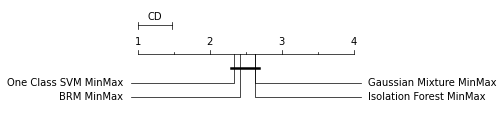

In [203]:
import Orange

names = ['One Class SVM MinMax', 'Isolation Forest MinMax', 'Gaussian Mixture MinMax', 'BRM MinMax']

avranks = [rankings_avg[0], rankings_avg[1], rankings_avg[2], rankings_avg[3]]

cd = Orange.evaluation.compute_CD(avranks, final_df.shape[0])
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
plt.show();

### Normalization: Standard Scaler

#### Friedman's test

In [204]:
alpha = 0.05 # significance level

result = stats.friedmanchisquare(final_df.AUC_OneClassSVM_Std, final_df.AUC_IsolationForest_Std, final_df.AUC_GaussianMixture_Std, final_df.AUC_BRM_Std)
result

FriedmanchisquareResult(statistic=3.17494600431964, pvalue=0.3654304625707986)

In [205]:
if result.pvalue < alpha:
  print("We can reject the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are not similar statistically. Therefore, we can proceed with a post-hoc test.")
else:
  print("We can accept the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are similar statistically.")

We can accept the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are similar statistically.


In [206]:
auc_data_std = {
    'AUC_OneClass_SVM_Std': final_df.AUC_OneClassSVM_Std,
    'AUC_Isolation_Forest_Std': final_df.AUC_IsolationForest_Std,
    'AUC_Gaussian_Mixture_Std': final_df.AUC_GaussianMixture_Std,
    'AUC_BRM_Std': final_df.AUC_BRM_Std,
}

In [207]:
rankings_avg = friedman_test(*auc_data_std.values())
rankings_avg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


[2.5210526315789474,
 2.6473684210526316,
 2.5105263157894737,
 2.3210526315789473]

#### Post-hoc test

In [208]:
data = np.array([final_df.AUC_OneClassSVM_Std, final_df.AUC_IsolationForest_Std, final_df.AUC_GaussianMixture_Std, final_df.AUC_BRM_Std])

In [209]:
p_values = sp.posthoc_nemenyi_friedman(data.T)
p_values

,0,1,2,3
0,1.000000,0.900000,0.900000,0.685841
1,0.900000,1.000000,0.875097,0.302046
2,0.900000,0.875097,1.000000,0.717386
3,0.685841,0.302046,0.717386,1.000000


In [210]:
ranks = {key: rankings_avg[i] for i, key in enumerate(auc_data_std.keys())}
ranks

{'AUC_BRM_Std': 2.3210526315789473,
 'AUC_Gaussian_Mixture_Std': 2.5105263157894737,
 'AUC_Isolation_Forest_Std': 2.6473684210526316,
 'AUC_OneClass_SVM_Std': 2.5210526315789474}

In [211]:
comparisons, z_values, p_values, adj_p_values = shaffer_multitest(ranks)
comparisons, z_values, p_values, adj_p_values

(['AUC_Isolation_Forest_Std vs AUC_BRM_Std',
  'AUC_OneClass_SVM_Std vs AUC_BRM_Std',
  'AUC_Gaussian_Mixture_Std vs AUC_BRM_Std',
  'AUC_Isolation_Forest_Std vs AUC_Gaussian_Mixture_Std',
  'AUC_OneClass_SVM_Std vs AUC_Isolation_Forest_Std',
  'AUC_OneClass_SVM_Std vs AUC_Gaussian_Mixture_Std'],
 [0.32631578947368434,
  0.20000000000000018,
  0.18947368421052646,
  0.13684210526315788,
  0.12631578947368416,
  0.010526315789473717],
 [0.7441854432140296,
  0.8414805811217938,
  0.8497215784715073,
  0.891155601487891,
  0.899481958176398,
  0.9916013702490789],
 [1, 1, 1, 1, 1, 1])

In [212]:
comparisons, z_values, p_values, adj_p_values = nemenyi_multitest(ranks)
comparisons, z_values, p_values, adj_p_values

(['AUC_OneClass_SVM_Std vs AUC_Isolation_Forest_Std',
  'AUC_OneClass_SVM_Std vs AUC_Gaussian_Mixture_Std',
  'AUC_OneClass_SVM_Std vs AUC_BRM_Std',
  'AUC_Isolation_Forest_Std vs AUC_Gaussian_Mixture_Std',
  'AUC_Isolation_Forest_Std vs AUC_BRM_Std',
  'AUC_Gaussian_Mixture_Std vs AUC_BRM_Std'],
 [0.12631578947368416,
  0.010526315789473717,
  0.20000000000000018,
  0.13684210526315788,
  0.32631578947368434,
  0.18947368421052646],
 [0.899481958176398,
  0.9916013702490789,
  0.8414805811217938,
  0.891155601487891,
  0.7441854432140296,
  0.8497215784715073],
 [1, 1, 1, 1, 1, 1])

#### Critical Difference Diagram

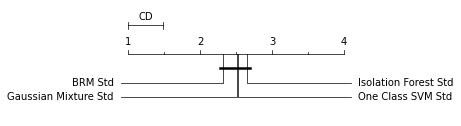

In [213]:
import Orange

names = ['One Class SVM Std', 'Isolation Forest Std', 'Gaussian Mixture Std', 'BRM Std']

avranks = [rankings_avg[0], rankings_avg[1], rankings_avg[2], rankings_avg[3]]

cd = Orange.evaluation.compute_CD(avranks, final_df.shape[0])
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
plt.show();